In [4]:
import sys
import os

py_file_location = "/content/Diabetes-prediction-classifier/Diabetes_Prediction_v1"
sys.path.append(os.path.abspath(py_file_location))

In [9]:
!git clone https://github.com/Maniaditya05/Diabetes-prediction-classifier.git

Cloning into 'Diabetes-prediction-classifier'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 38 (delta 5), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (38/38), done.


[       SEQN  URXUMA  URXUMS  URXUCR.x  ...  URXPREG  URXUAS  LBDB12  LBDB12SI
0     73557     4.3     4.3      39.0  ...      NaN     NaN   524.0     386.7
1     73558   153.0   153.0      50.0  ...      NaN     NaN   507.0     374.2
2     73559    11.9    11.9     113.0  ...      NaN     NaN   732.0     540.2
3     73560    16.0    16.0      76.0  ...      NaN    3.83     NaN       NaN
4     73561   255.0   255.0     147.0  ...      NaN     NaN   225.0     166.1
...     ...     ...     ...       ...  ...      ...     ...     ...       ...
9808  83727     1.9     1.9      47.0  ...      NaN     NaN   720.0     531.4
9809  83728     NaN     NaN       NaN  ...      NaN     NaN     NaN       NaN
9810  83729     6.0     6.0     117.0  ...      2.0    9.75   388.0     286.3
9811  83730     4.5     4.5      86.0  ...      NaN     NaN     NaN       NaN
9812  83731     5.3     5.3     114.0  ...      NaN    7.25     NaN       NaN

[9813 rows x 424 columns],        SEQN  PEASCST1  PEASCTM1  PE

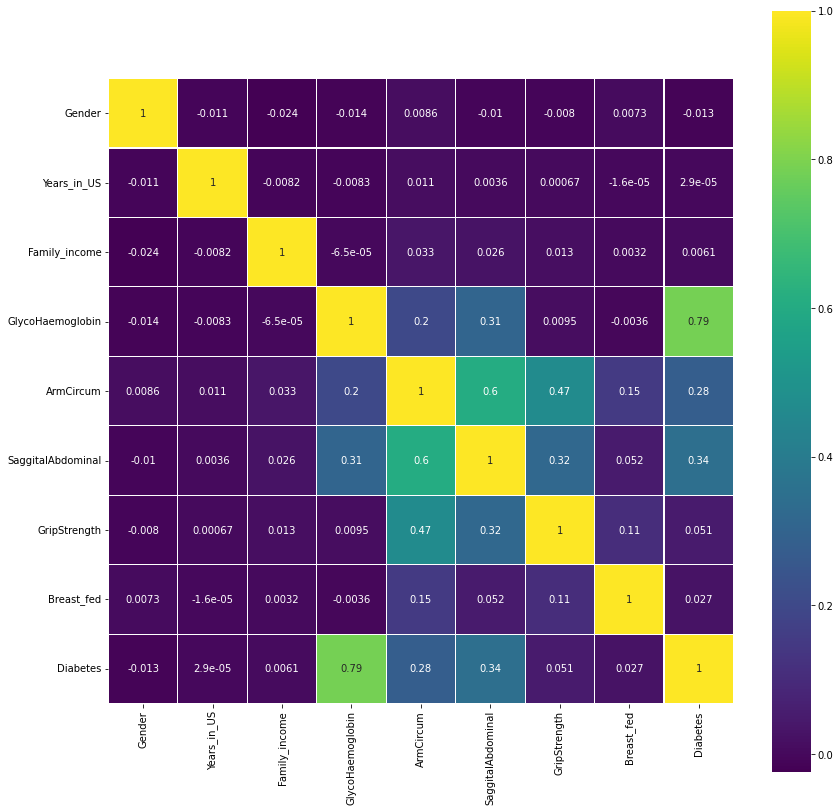

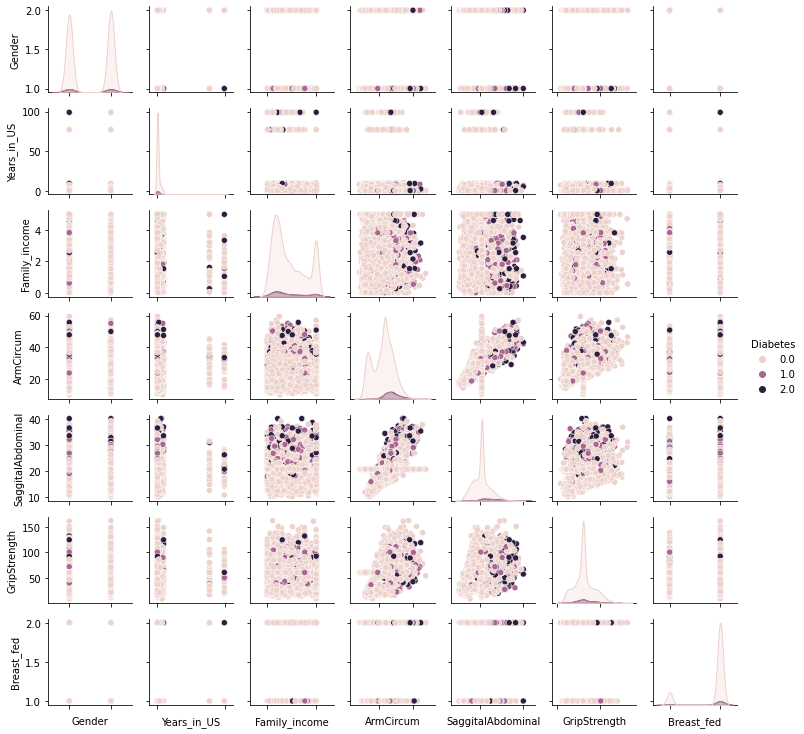

In [10]:
import matplotlib.pyplot as plot
import pandas
import sklearn
from sklearn.feature_selection import VarianceThreshold
import matplotlib.pyplot as plot
import seaborn
from sklearn import linear_model
from sklearn.svm import SVC 
from sklearn.metrics import mean_squared_error, r2_score, recall_score, precision_score

class Model:

    def __init__(self, dataset_file_path, dataset_filenames):
        self.dataset_filenames = dataset_filenames
        self.dataset_file_path = dataset_file_path 
    

    def read_dataset(self):
        dataframes = []

        for dataset in self.dataset_filenames:
            dataframe = pandas.read_csv(self.dataset_file_path + '/' + dataset)
            dataframes.append(dataframe)

        return dataframes
    
    def merge_and_select_attribute(self, dataframes_read):
        dataframes = dataframes_read
        
        for dataframe in dataframes[2:]:
            dataframe.drop(['SEQN'], axis=1, inplace=True)
  
        dataframe = pandas.concat(dataframes, axis=1, join='inner')

        return dataframe

    def imputate_dataframe(self, dataframe):
        if dataframe.isnull().values.any():
            dataframe.dropna(axis=1, how="all")
            dataframe.dropna(axis=0, how="all") 

            return dataframe
        else:
            return dataframe
    
    def feature_selection(self, dataframe):
        merged_dataframe = dataframe 

        columns_to_rename = {
            'SEQN': 'ID',
            'RIAGENDR': 'Gender',
            'DMDYRSUS': 'Years_in_US',
            'INDFMPIR': 'Family_income',
            'LBXGH': 'GlycoHaemoglobin',
            'BMXARMC': 'ArmCircum',
            'BMDAVSAD': 'SaggitalAbdominal',
            'MGDCGSZ': 'GripStrength',
            'DRABF': 'Breast_fed'
        }

        merged_dataframe = merged_dataframe.rename(columns=columns_to_rename)

        merged_dataframe = merged_dataframe.loc[:, ['ID', 'Gender', 'Years_in_US', 'Family_income', 'GlycoHaemoglobin', 'ArmCircum', 'SaggitalAbdominal', 'GripStrength', 'Breast_fed']]

        return merged_dataframe
    
    def ValuesManipulations(self, dataframe):
        if dataframe.isnull().values.any():  
            dataframe['Years_in_US'] = dataframe['Years_in_US'].apply(lambda x: x if x > 0 else 0)
            dataframe['GlycoHaemoglobin'] = dataframe['GlycoHaemoglobin'].fillna( dataframe['GlycoHaemoglobin'].median())
            dataframe['SaggitalAbdominal'] = dataframe['SaggitalAbdominal'].fillna(dataframe['SaggitalAbdominal'].median())
            dataframe['ArmCircum'] = dataframe['ArmCircum'].fillna(dataframe['ArmCircum'].median())
            dataframe['GripStrength'] = dataframe['GripStrength'].fillna(dataframe['GripStrength'].median())
            dataframe['Family_income'] = dataframe['Family_income'].fillna(method='ffill')
            dataframe['Breast_fed'] = dataframe['Breast_fed'].fillna(value=1)

            set_threshold_value = VarianceThreshold(threshold=(.8 * (1 - .8)))
            set_threshold_value.fit_transform(dataframe)

            dataframe.loc[dataframe['GlycoHaemoglobin'] < 6.0, 'Diabetes'] = 0
            dataframe.loc[(dataframe['GlycoHaemoglobin'] >= 6.0) & (dataframe['GlycoHaemoglobin'] <= 6.4), 'Diabetes'] = 1
            dataframe.loc[dataframe['GlycoHaemoglobin'] >= 6.5, 'Diabetes'] = 2

            dataframe.head(10)

            return dataframe
        else:
            return dataframe
    
    def labels_plot_visualize(self, dataframe):
        colormap = plot.cm.viridis

        plot.figure(figsize=(14, 14))
        seaborn.heatmap(dataframe.astype(float).drop(axis=1, labels='ID').corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, annot=True)
        
        diabetes_diagram_representation = seaborn.pairplot(dataframe.drop(['ID', 'GlycoHaemoglobin'], axis=1), hue='Diabetes', height=1.5, diag_kind='kde')
        diabetes_diagram_representation.set(xticklabels=[])

        return plot

    def drop_off_haemoglobin_column(self, dataframe):
        dataframe.drop(['GlycoHaemoglobin'], axis=1, inplace=True)
        dataframe.head(5)

        return dataframe

    def dataset_split(self, dataframe):
        data = dataframe.drop(['Diabetes'], axis=1)
        target = dataframe[['Diabetes']]

        #seperate training set and test set
        x_train = data[:6000]
        x_test = data[6000:]

        y_train = target[:6000]
        y_test = target[6000:]

        return [x_train, x_test, y_train, y_test]
    
    def diabetes_prediction_model(self, dataframe): 
        linear_regression = linear_model.LinearRegression()

        # train our data on linear regression classifier 
        linear_regression.fit(self.dataset_split(dataframe)[0], self.dataset_split(dataframe)[2])

        model = linear_regression

        return model

    def predict_diabetes(self, model, dataframe):  
        prediction = model.predict(self.dataset_split(dataframe)[1])

        linear_regression_score = model.score(self.dataset_split(dataframe)[1], self.dataset_split(dataframe)[3])
        
        return [prediction, linear_regression_score]
        
    def visualize_model_performance(self, model, dataframe):
        print('Linear Regression Coefficients: ', model.coef_)
        print('Linear Regression Mean Square Error: %.2f' % mean_squared_error(self.dataset_split(dataframe)[3], self.predict_diabetes(model, dataframe)[0]))
        print('Linear Regression Variance score: %.2f' % r2_score(self.dataset_split(dataframe)[3], self.predict_diabetes(model, dataframe)[0]))
        print('Linear Regression Score: %.2f' % self.predict_diabetes(model, dataframe)[1])
        


# DATASET csv file path
csv_file_path = './Diabetes-prediction-classifier/Diabetes_Prediction_v1/public/csv' 
labs = 'labs.csv'
examination = 'examination.csv'
demographic = 'demographic.csv'
diet = 'diet.csv'
questionnaire = 'questionnaire.csv'

csv_file_names = [labs,
                 examination,
                 demographic,
                 diet,
                 questionnaire]

# print dataframe
DiabetesModel = Model(csv_file_path, csv_file_names)


# print pandas dataframe 
dataframe = DiabetesModel.read_dataset()
print(dataframe)

merged_dataframe = DiabetesModel.merge_and_select_attribute(dataframe)
print(merged_dataframe.describe())

# imputation of our dataframe
imputed_dataframe = DiabetesModel.imputate_dataframe(merged_dataframe)
print(imputed_dataframe.describe())

# feature selection
dataframe_done_feature_selection = DiabetesModel.feature_selection(imputed_dataframe)
print(dataframe_done_feature_selection.describe())

dataframe_done_values_manipulations = DiabetesModel.ValuesManipulations(dataframe_done_feature_selection)
print(dataframe_done_values_manipulations.describe())

LabelVisualize = DiabetesModel.labels_plot_visualize(dataframe_done_values_manipulations)

dataframe_dropped_off_haemoglobin = DiabetesModel.drop_off_haemoglobin_column(dataframe_done_values_manipulations)
print(dataframe_dropped_off_haemoglobin)

model = DiabetesModel.diabetes_prediction_model(dataframe_dropped_off_haemoglobin)

predictions = DiabetesModel.predict_diabetes(model, dataframe_done_values_manipulations)

if (predictions):
    visalizations = DiabetesModel.visualize_model_performance(
        model, dataframe_dropped_off_haemoglobin)


LabelVisualize.show()


